In [13]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from itertools import combinations as cb
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
price_df = pd.read_csv('./Data/us_etf_price.csv', parse_dates=['Date'])
price_df = price_df.pivot(columns='tic', values='Adj Close', index='Date')
etf_info = pd.read_csv('./Data/etfs_details_equity.csv')

In [3]:
monthly = pd.date_range('2009-12-31', '2022-1-1', freq='MS')

period_candi = [(3,1),(6,1),(12,1),(24,12)]

formation_train = {}
for cnd in period_candi:

    train_window_width = cnd[0]
    test_window_width = cnd[1]

    train_period = []
    test_period = []
    for i in range(len(monthly)- train_window_width-test_window_width):
        train_start_date = monthly[i]
        train_end_date = monthly[i+train_window_width]
        test_end_date = monthly[i+train_window_width+test_window_width]

        if test_end_date.year < 2017:

            train_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
        
        elif test_end_date.year >=2017:

            test_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
            
    formation_train[cnd] = (train_period, test_period)

In [4]:
performance_test = formation_train[(24,12)][1][48:60]
performance_test

[('2018-01-01', '2020-01-01', '2021-01-01'),
 ('2018-02-01', '2020-02-01', '2021-02-01'),
 ('2018-03-01', '2020-03-01', '2021-03-01'),
 ('2018-04-01', '2020-04-01', '2021-04-01'),
 ('2018-05-01', '2020-05-01', '2021-05-01'),
 ('2018-06-01', '2020-06-01', '2021-06-01'),
 ('2018-07-01', '2020-07-01', '2021-07-01'),
 ('2018-08-01', '2020-08-01', '2021-08-01'),
 ('2018-09-01', '2020-09-01', '2021-09-01'),
 ('2018-10-01', '2020-10-01', '2021-10-01'),
 ('2018-11-01', '2020-11-01', '2021-11-01'),
 ('2018-12-01', '2020-12-01', '2021-12-01')]

In [5]:
df_formation = price_df.loc[performance_test[0][0]:performance_test[-1][1]]
df_trading = price_df.loc[performance_test[0][2]:performance_test[-1][2]]

In [202]:
# with open('1901~1912_pair_reg.pkl','rb') as f:
#     df = pickle.load(f)

In [6]:
with open('2020~2021_pair_reg.pkl','rb') as f:
    df = pickle.load(f)

In [7]:
'''1번째 기간'''
idx = 0

df_formation = price_df.loc[performance_test[idx][0]:performance_test[idx][1]]
df_trading = price_df.loc[performance_test[idx][1]:performance_test[idx][2]]

pair_list = []
for x in df[idx][0]:
    if x == []:
        pass
    else:
        for pair in x:
            pair_list.append(pair)

pair_list

[('SPDN', 'SH'), ('SPY', 'IVV'), ('VONE', 'VV'), ('SPLG', 'SCHX')]

In [8]:
pair = pair_list[1]

pair_trading_df = df_trading.loc[:, pair]
pair_formation_df = df_formation.loc[:, pair]

In [9]:
pair_formation_df

tic,SPY,IVV
Date,,
2018-01-02,247.899826,248.559143
2018-01-03,249.467819,249.999908
2018-01-04,250.519226,251.082870
2018-01-05,252.188736,252.670425
2018-01-08,252.649872,253.230255
...,...,...
2019-12-24,307.631165,308.725708
2019-12-26,309.268707,310.323578
2019-12-27,309.192078,310.266144


In [10]:
from pykalman import KalmanFilter

def kf_A (x):

    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

def kf_R (x, y):
    
    delta = 1e-6
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means   

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    
    spread_lag2 = sm.add_constant(spread_lag)
     
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
 
    if halflife <= 0:
        halflife = 1
    return halflife

In [21]:
np.c_[X.values.reshape(-1,1), np.ones(len(X)).reshape(-1)] @ beta_arr

array([[4.73680835, 1.        ],
       [4.74432504, 1.        ],
       [4.74834321, 1.        ],
       ...,
       [4.95530673, 1.        ],
       [4.94879852, 1.        ],
       [4.95185447, 1.        ]])

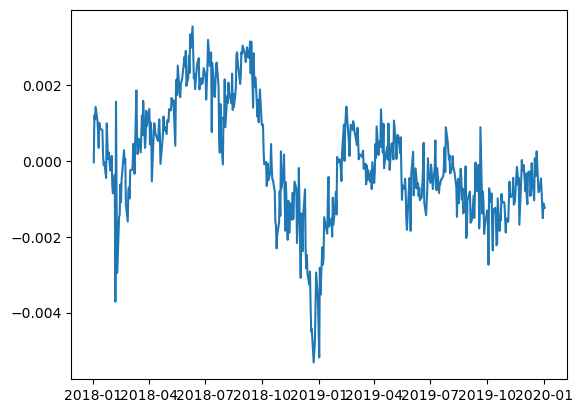

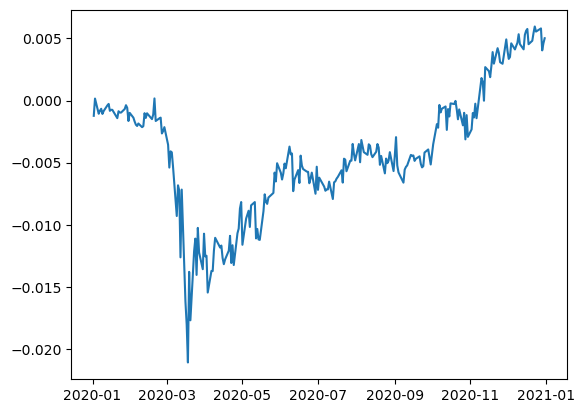

In [61]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

pair_trading_df = df_trading.loc[:, pair]
pair_formation_df = df_formation.loc[:, pair]

log_df_form = np.log(pair_formation_df)
log_df_trade = np.log(pair_trading_df)

X = log_df_form[pair[0]]
Y = log_df_form[pair[1]]
x = log_df_trade[pair[0]]
y = log_df_trade[pair[1]]

df1 = pd.DataFrame({'y':Y, 'x':X})
df2 = pd.DataFrame({'y':y, 'x':x})

lr.fit(X.values.reshape(-1, 1), Y.values.reshape(-1, 1))

lr_coef = lr.coef_.item()
lr_intercept = lr.intercept_.item()

beta_arr = np.array([lr_coef, lr_intercept])

hedge_ratio = lr_coef
hedge_ratio

spread = np.c_[X.values.reshape(-1,1), np.ones(len(X)).reshape(-1)] @ beta_arr - np.array(Y).flatten()

df1['spread'] = spread

for num, idx in enumerate(df2.index):

    df1.loc[idx, ['y', 'x']] = df2.loc[idx, ['y', 'x']]
    
    X = df1.x
    Y = df1.y

    lr.fit(X.values.reshape(-1, 1), Y.values.reshape(-1, 1))

    lr_coef = lr.coef_.item()
    lr_intercept = lr.intercept_.item()

    beta_arr = np.array([lr_coef, lr_intercept])

    hedge_ratio = lr_coef
    hedge_ratio

    spread = np.c_[X.values.reshape(-1,1), np.ones(len(X)).reshape(-1)] @ beta_arr - np.array(Y).flatten()

    df1.loc[idx, ['y', 'x']] = df2.loc[idx, ['y', 'x']]
    df1.loc[idx, 'spread'] = spread[-1]
    


# lr.fit(X.values.reshape(-1, 1), Y.values.reshape(-1, 1))

# lr_coef = lr.coef_.item()
# lr_intercept = lr.intercept_.item()

# beta_arr = np.array([lr_coef, lr_intercept])

# hedge_ratio = lr_coef
# hedge_ratio

# spread = np.c_[X.values.reshape(-1,1), np.ones(len(X)).reshape(-1)] @ beta_arr - np.array(Y).flatten()

# df1['spread'] = spread

# state_means = kf_R(kf_A(X), kf_A(Y))

# df1['kalman_spread'] = df1.y - df1.x * state_means[:,0]
plt.plot(df1['spread'].loc[:df_trading.index[0]])
plt.show()
plt.plot(df1['spread'].loc[df_trading.index[0]:])
#plt.plot(df1.kalman_spread, label='kalman')


In [59]:
df1['spread'].loc[:df_trading.index[0]]

Date
2018-01-02   -0.000037
2018-01-03    0.001202
2018-01-04    0.001097
2018-01-05    0.001429
2018-01-08    0.001057
                ...   
2019-12-26   -0.000592
2019-12-27   -0.000460
2019-12-30   -0.001508
2019-12-31   -0.001121
2020-01-02   -0.001231
Name: spread, Length: 504, dtype: float64

Hurst Exponent and Half-life

H < 0.5 일 때, Mean Reverting <br>
H = 0.5 일 때, Geometric Brownian Motion <br>
H > 0.5 일 때, Trending <br>

In [42]:
spread

array([-3.67555295e-05,  1.20193720e-03,  1.09734161e-03,  1.42922871e-03,
        1.05697970e-03,  7.68202852e-04,  3.43657246e-04,  1.00611249e-03,
        8.64746125e-04,  8.15428615e-04,  1.59913673e-04, -9.65133194e-05,
       -2.76885840e-05, -4.47300872e-04,  9.93427372e-04,  5.17693485e-04,
        5.55648677e-05,  2.31181065e-04, -2.56010587e-04, -1.93000980e-04,
        1.36383695e-04, -6.56248836e-04, -8.53852315e-04, -3.64765135e-04,
       -3.71205878e-03,  1.56247864e-03, -1.07505969e-03, -2.95514143e-03,
       -1.47094051e-03, -1.42000200e-03, -6.22063629e-04, -1.08506191e-03,
       -5.09817570e-04,  2.84345476e-04, -3.71471152e-05,  5.65135526e-05,
       -1.14895886e-03, -1.59838736e-03, -7.64445112e-04, -6.95400527e-04,
       -9.87590377e-04, -2.42720285e-04, -2.32968585e-04, -1.09182767e-04,
        4.52038629e-04,  1.15197059e-04, -3.36643064e-04,  1.86114793e-03,
        6.58204284e-04,  1.83634430e-04,  4.10808462e-04,  5.85407774e-04,
        2.25879815e-04,  

In [465]:
pair_list[0]

('SPDN', 'SH')

In [11]:
def reg_df_cal (df, entryz = 0.5, exitz = 0):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.z < - entryz) & ( df1.z.shift(1) > - entryz))
    df1['long exit'] = ((df1.z > - exitz) & (df1.z.shift(1) < - exitz)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.z >  entryz) & ( df1.z.shift(1) < entryz))
    df1['short exit'] = ((df1.z < exitz) & (df1.z.shift(1) > exitz))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hedge_ratio'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    df = df1

    return df

def reg_sharpe_cal (df, entryz = 0.5, exitz = 0):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.z < - entryz) & ( df1.z.shift(1) > - entryz))
    df1['long exit'] = ((df1.z > - exitz) & (df1.z.shift(1) < - exitz)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.z >  entryz) & ( df1.z.shift(1) < entryz))
    df1['short exit'] = ((df1.z < exitz) & (df1.z.shift(1) > exitz))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hedge_ratio'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    return sharpe

In [14]:
pair = pair_list[2]

pair_trading_df = df_trading.loc[:, pair]
pair_formation_df = df_formation.loc[:, pair]

log_df_form = np.log(pair_formation_df)
log_df_trade = np.log(pair_trading_df)

X = log_df_form[pair[0]]
Y = log_df_form[pair[1]]
x = log_df_trade[pair[0]]
y = log_df_trade[pair[1]]

df1 = pd.DataFrame({'y':Y, 'x':X})
df2 = pd.DataFrame({'y':y, 'x':x})

state_means = kf_R(kf_A(X), kf_A(Y))

df1['hedge_ratio'] = - state_means[:,0]
df1['spread'] = df1.y + df1.x * df1.hedge_ratio

halflife = half_life(df1['spread'])

mean_spread = df1['spread'].rolling(halflife).mean()
std_spread  = df1['spread'].rolling(halflife).std()

df1['z'] = (df1['spread'] - mean_spread)/std_spread

z_test_list = []
for comb in list(cb(np.arange(-1, 1, 0.03), 2)):
    if comb[0] < comb[1]:
        z_test_list.append((comb[1], comb[0]))
    else:
        pass
z_test_list

opt_sharpe = {}

for idx in tqdm(z_test_list):
    opt_sharpe[idx] = reg_sharpe_cal(df1, idx[0], idx[1])
        
opt_z = max(opt_sharpe, key=opt_sharpe.get)

print(f'opt z = {opt_z}, sharpe = {max(opt_sharpe.values())}')

entryz = opt_z[0]
exitz = opt_z[1]

# #df1 = pd.DataFrame({'y':Y, 'x':X})
# df1 = pd.DataFrame()
# df2 = pd.DataFrame({'y':y, 'x':x})

# for num, idx in enumerate(df2.index):

#     if num > 2:
#         df1 = pd.concat([df1, df2.loc[[idx]]])
#         state_means = kf_R(kf_A(df1.x), kf_A(df1.y))

#         df1['hedge_ratio'] = - state_means[:,0]
#         df1['spread'] = df1.y + df1.x * df1.hedge_ratio

#         halflife = half_life(df1['spread'])

#         mean_spread = df1['spread'].rolling(halflife).mean()
#         std_spread  = df1['spread'].rolling(halflife).std()

#         df1['z'] = (df1['spread'] - mean_spread)/std_spread

#     else:
#         df1 = pd.concat([df1, df2.loc[[idx]]])

# df1

entryz = opt_z[0]
exitz = opt_z[1]

df1 = reg_df_cal(df1, entryz, exitz)
sharpe = reg_sharpe_cal(df1, entryz, exitz)

print(sharpe)
df1

100%|██████████| 19900/19900 [00:34<00:00, 571.47it/s]

opt z = (0.7100000000000015, -1.0), sharpe = 1.2683215861887993
1.2683215861887993


,y,x,hedge_ratio,spread,z,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2018-01-02,4.734723,4.736808,-0.597493,1.904513,NaN,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2018-01-03,4.741100,4.744325,-0.689346,1.470616,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.054159,-0.000000,1.000000
2018-01-04,4.745275,4.748343,-0.726539,1.295417,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.021378,-0.000000,1.000000
2018-01-05,4.751665,4.754978,-0.746977,1.199807,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.011514,-0.000000,1.000000
2018-01-08,4.753892,4.756808,-0.760044,1.138507,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.007325,-0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,4.951988,4.950497,-0.827711,0.854409,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.000005,-0.000000,1.004398
2019-12-26,4.956854,4.955509,-0.827729,0.855037,0.707107,False,False,0.0,False,False,-1.0,-1.0,0.000069,0.000000,1.004398
2019-12-27,4.956517,4.955307,-0.827747,0.854778,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.000029,0.000029,1.004426


In [375]:
X = log_df_form[pair[0]]
Y = log_df_form[pair[1]]
x = log_df_trade[pair[0]]
y = log_df_trade[pair[1]]

df1 = pd.DataFrame({'y':Y, 'x':X})
df2 = pd.DataFrame({'y':y, 'x':x})

In [470]:
lr = LinearRegression()
lr.fit(df1.x.to_numpy().reshape(-1,1), df1.y.to_numpy().reshape(-1, 1))

beta, intercept = lr.coef_.item(), lr.intercept_.item()

df2['spread'] = df2.x * beta + intercept - df2.y
df2['hedge_ratio'] = [beta for x in df2.index]

halflife = half_life(df2['spread'])

mean_spread = df2['spread'].rolling(halflife).mean()
std_spread  = df2['spread'].rolling(halflife).std()

df2['z'] = (df2['spread'] - mean_spread)/std_spread


entryz = opt_z[0]
exitz = opt_z[1]

reg_sharpe_cal(df2, entryz, exitz)

3.058051673993763

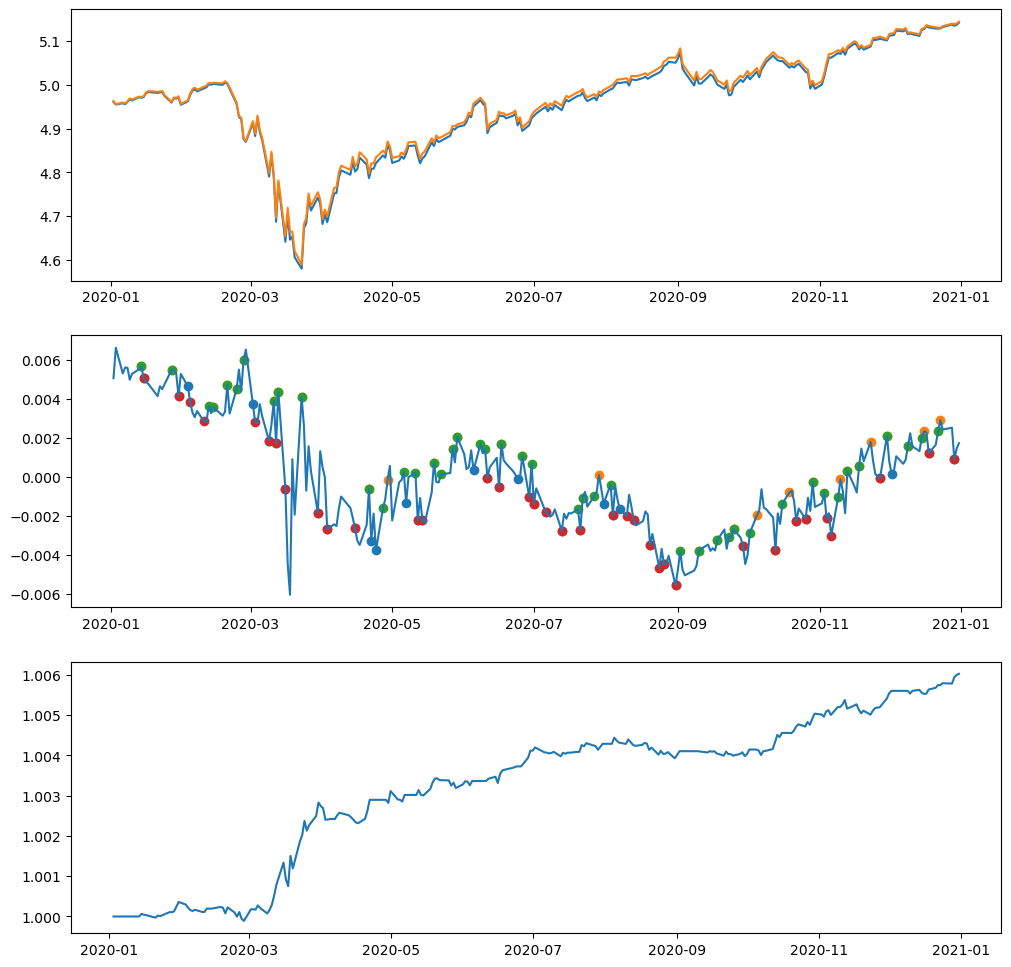

In [471]:
plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
plt.plot(df2.x)
plt.plot(df2.y)

plt.subplot(3,1,2)
#plt.plot(df2.spread)
plt.plot(df2.spread)
plt.scatter(df2.index, np.where(df2['long entry'] == True, df2.spread, np.nan))
plt.scatter(df2.index, np.where(df2['long exit'] == True, df2.spread, np.nan))
plt.scatter(df2.index, np.where(df2['short entry'] == True, df2.spread, np.nan))
plt.scatter(df2.index, np.where(df2['short exit'] == True, df2.spread, np.nan))

plt.subplot(3,1,3)
plt.plot(df2['cum rets'])


In [477]:
pair = pair_list[2]

pair_trading_df = df_trading.loc[:, pair]
pair_formation_df = df_formation.loc[:, pair]

log_df_form = np.log(pair_formation_df)
log_df_trade = np.log(pair_trading_df)

X = log_df_form[pair[0]]
Y = log_df_form[pair[1]]
x = log_df_trade[pair[0]]
y = log_df_trade[pair[1]]

df1 = pd.DataFrame({'y':Y, 'x':X})
df2 = pd.DataFrame({'y':y, 'x':x})

state_means = kf_R(kf_A(X), kf_A(Y))

df1['hedge_ratio'] = - state_means[:,0]
df1['spread'] = df1.y + df1.x * df1.hedge_ratio

halflife = half_life(df1['spread'])

mean_spread = df1['spread'].rolling(halflife).mean()
std_spread  = df1['spread'].rolling(halflife).std()

df1['z'] = (df1['spread'] - mean_spread)/std_spread

z_test_list = []
for comb in list(cb(np.arange(-1, 0.7, 0.01), 2)):
    if comb[0] < comb[1]:
        z_test_list.append((comb[1], comb[0]))
    else:
        pass
z_test_list

opt_sharpe = {}

for idx in tqdm(z_test_list):
    opt_sharpe[idx] = reg_sharpe_cal(df1, idx[0], idx[1])
        
opt_z = max(opt_sharpe, key=opt_sharpe.get)

print(f'opt z = {opt_z}, sharpe = {max(opt_sharpe.values())}')

entryz = opt_z[0]
exitz = opt_z[1]

df1 = reg_df_cal(df1, entryz, exitz)
sharpe = reg_sharpe_cal(df1, entryz, exitz)

print(sharpe)
df1

100%|██████████| 14365/14365 [00:27<00:00, 525.37it/s]

opt z = (-0.98, -0.99), sharpe = 1.2683215861887993
1.2683215861887993


,y,x,hedge_ratio,spread,z,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2018-01-02,4.734723,4.736808,-0.597493,1.904513,NaN,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2018-01-03,4.741100,4.744325,-0.689346,1.470616,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.054159,-0.000000,1.000000
2018-01-04,4.745275,4.748343,-0.726539,1.295417,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.021378,-0.000000,1.000000
2018-01-05,4.751665,4.754978,-0.746977,1.199807,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.011514,-0.000000,1.000000
2018-01-08,4.753892,4.756808,-0.760044,1.138507,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.007325,-0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,4.951988,4.950497,-0.827711,0.854409,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.000005,-0.000000,1.004398
2019-12-26,4.956854,4.955509,-0.827729,0.855037,0.707107,False,False,0.0,False,False,-1.0,-1.0,0.000069,0.000000,1.004398
2019-12-27,4.956517,4.955307,-0.827747,0.854778,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.000029,0.000029,1.004426


In [478]:
df1

,y,x,hedge_ratio,spread,z,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2018-01-02,4.734723,4.736808,-0.597493,1.904513,NaN,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2018-01-03,4.741100,4.744325,-0.689346,1.470616,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.054159,-0.000000,1.000000
2018-01-04,4.745275,4.748343,-0.726539,1.295417,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.021378,-0.000000,1.000000
2018-01-05,4.751665,4.754978,-0.746977,1.199807,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.011514,-0.000000,1.000000
2018-01-08,4.753892,4.756808,-0.760044,1.138507,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.007325,-0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,4.951988,4.950497,-0.827711,0.854409,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.000005,-0.000000,1.004398
2019-12-26,4.956854,4.955509,-0.827729,0.855037,0.707107,False,False,0.0,False,False,-1.0,-1.0,0.000069,0.000000,1.004398
2019-12-27,4.956517,4.955307,-0.827747,0.854778,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.000029,0.000029,1.004426


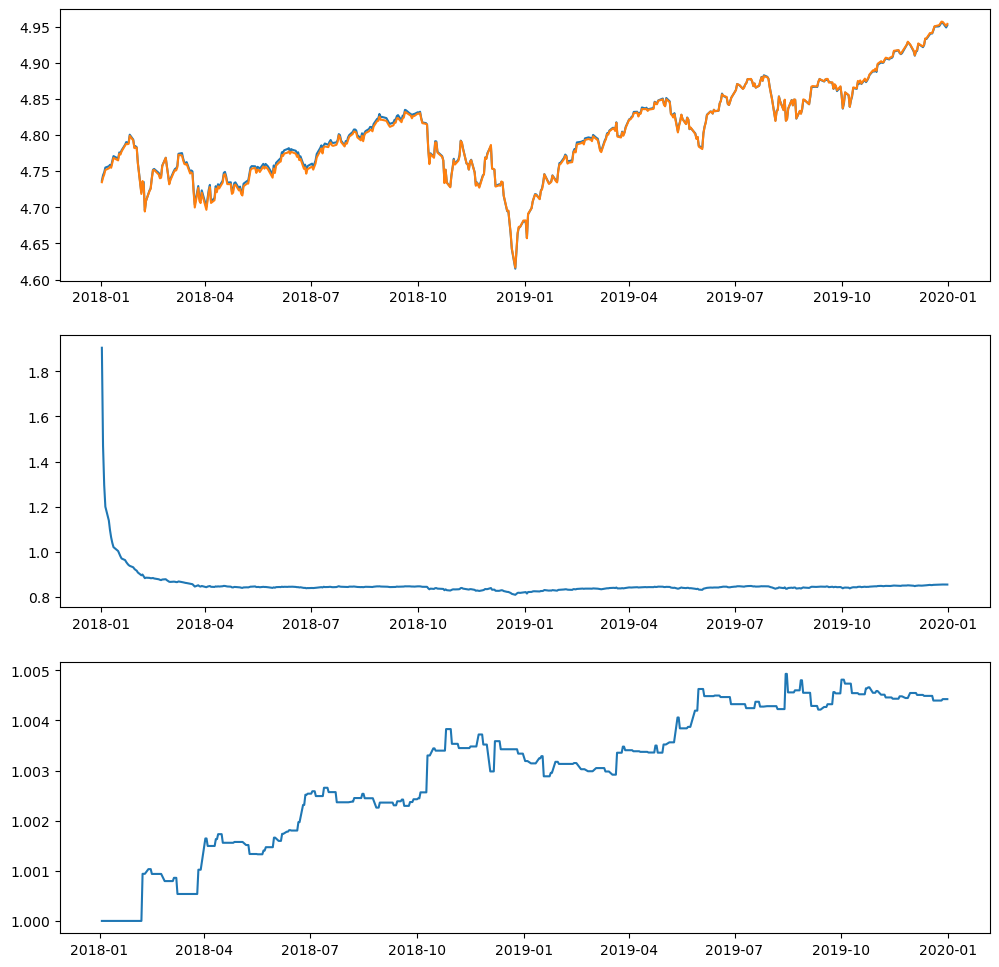

In [479]:
plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
plt.plot(df1.x)
plt.plot(df1.y)

plt.subplot(3,1,2)
#plt.plot(df1.spread)
plt.plot(df1.spread)
plt.scatter(df1.index, np.where(df1['long entry'] == True, df1.spread, np.nan), color='yellow')
plt.scatter(df1.index, np.where(df1['long exit'] == True, df1.spread, np.nan), color='green')
plt.scatter(df1.index, np.where(df1['short entry'] == True, df1.spread, np.nan), color='red')
plt.scatter(df1.index, np.where(df1['short exit'] == True, df1.spread, np.nan), color='purple')

plt.subplot(3,1,3)
plt.plot(df1['cum rets'])


In [383]:
beta

array([[1.02660762]])

In [357]:
pair = pair_list[1]

pair_trading_df = df_trading.loc[:, pair]
pair_formation_df = df_formation.loc[:, pair]

log_df_form = np.log(pair_formation_df)
log_df_trade = np.log(pair_trading_df)

X = log_df_form[pair[0]]
Y = log_df_form[pair[1]]
x = log_df_trade[pair[0]]
y = log_df_trade[pair[1]]

df1 = pd.DataFrame({'y':y, 'x':x})

state_means = kf_R(kf_A(x), kf_A(y))

df1['hedge_ratio'] = - state_means[:,0]
df1['spread'] = df1.y + df1.x * df1.hedge_ratio

halflife = half_life(df1['spread'])

mean_spread = df1['spread'].rolling(halflife).mean()
std_spread  = df1['spread'].rolling(halflife).std()

df1['z'] = (df1['spread'] - mean_spread)/std_spread

In [313]:
max(opt_sharpe.values())
max(opt_sharpe, key=opt_sharpe.get)

(0.7100000000000015, -1.0)

In [236]:
pair_trading_df = df_trading.loc[:, pair]
pair_formation_df = df_formation.loc[:, pair]

log_df = pair_formation_df

X = log_df[pair[0]]
Y = log_df[pair[1]]

df1 = pd.DataFrame({'y':Y,'x':X})

X = log_df[pair[0]]
Y = log_df[pair[1]]

state_means = kf_R(kf_A(X), kf_A(Y))

df1['hedge_ratio'] = - state_means[:,0]

df1['spread'] = df1.y + df1.x * df1.hedge_ratio

'''half-life'''
halflife = half_life(df1['spread'])

'''half-life 에서 Mean 추정'''
mean_spread = df1['spread'].rolling(halflife).mean()
std_spread  = df1['spread'].rolling(halflife).std()

df1['z'] = (df1['spread'] - mean_spread)/std_spread



In [ ]:
df2['long entry'] = ((df2.z < - entryz) & ( df2.z.shift(1) > - entryz))
df2['long exit'] = ((df2.z > - exitz) & (df2.z.shift(1) < - exitz)) 
df2['num units long'] = np.nan 
df2.loc[df2['long entry'],'num units long'] = 1 
df2.loc[df2['long exit'],'num units long'] = 0
df2['num units long'][0] = 0 
df2['num units long'] = df2['num units long'].fillna(method='pad')

# Set up num units short 
df2['short entry'] = ((df2.z >  entryz) & ( df2.z.shift(1) < entryz))
df2['short exit'] = ((df2.z < exitz) & (df2.z.shift(1) > exitz))
df2.loc[df2['short entry'],'num units short'] = -1
df2.loc[df2['short exit'],'num units short'] = 0
df2['num units short'][0] = 0
df2['num units short'] = df2['num units short'].fillna(method='pad')

df2['numUnits'] = df2['num units long'] + df2['num units short']
df2['spread pct ch'] = (df2['spread'] - df2['spread'].shift(1)) / ((df2['x'] * abs(df2['hedge_ratio'])) + df2['y'])
df2['port rets'] = df2['spread pct ch'] * df2['numUnits'].shift(1)

df2['cum rets'] = df2['port rets'].cumsum()
df2['cum rets'] = df2['cum rets'] + 1

try:
    sharpe = ((df2['port rets'].mean() / df2['port rets'].std()) * np.sqrt(252)) 
except ZeroDivisionError:
    sharpe = 0.0

#############################################################
df2['cum rets'], sharpe

In [237]:
entryz = 0.5
exitz = 0

# Set up num units long             
df1['long entry'] = ((df1.z < - entryz) & ( df1.z.shift(1) > - entryz))
df1['long exit'] = ((df1.z > - exitz) & (df1.z.shift(1) < - exitz)) 
df1['num units long'] = np.nan 
df1.loc[df1['long entry'],'num units long'] = 1 
df1.loc[df1['long exit'],'num units long'] = 0
df1['num units long'][0] = 0 
df1['num units long'] = df1['num units long'].fillna(method='pad')

# Set up num units short 
df1['short entry'] = ((df1.z >  entryz) & ( df1.z.shift(1) < entryz))
df1['short exit'] = ((df1.z < exitz) & (df1.z.shift(1) > exitz))
df1.loc[df1['short entry'],'num units short'] = -1
df1.loc[df1['short exit'],'num units short'] = 0
df1['num units short'][0] = 0
df1['num units short'] = df1['num units short'].fillna(method='pad')

df1['numUnits'] = df1['num units long'] + df1['num units short']
df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hedge_ratio'])) + df1['y'])
df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

df1['cum rets'] = df1['port rets'].cumsum()
df1['cum rets'] = df1['cum rets'] + 1

try:
    sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
except ZeroDivisionError:
    sharpe = 0.0

#############################################################
df1['cum rets'], sharpe

/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_77148/3816430759.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num units long'][0] = 0
/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_77148/3816430759.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num units short'][0] = 0


(Date
 2019-01-02         NaN
 2019-01-03    1.000000
 2019-01-04    1.000000
 2019-01-07    1.000000
 2019-01-08    1.000000
                 ...   
 2019-12-24    1.002522
 2019-12-26    1.002565
 2019-12-27    1.002615
 2019-12-30    1.002573
 2019-12-31    1.002558
 Name: cum rets, Length: 252, dtype: float64,
 1.0747085364096962)

In [238]:
df1

,y,x,hedge_ratio,spread,z,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2019-01-02,4.681891,4.679580,-0.594355,1.900558,NaN,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2019-01-03,4.657216,4.657564,-0.686616,1.459257,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.056180,-0.000000,1.000000
2019-01-04,4.691076,4.690278,-0.724501,1.292964,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.020558,-0.000000,1.000000
2019-01-07,4.698637,4.698979,-0.745554,1.195294,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.011908,-0.000000,1.000000
2019-01-08,4.708264,4.708030,-0.759217,1.133847,-0.707107,False,False,0.0,False,False,0.0,0.0,-0.007419,-0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,4.951988,4.950497,-0.836611,0.810349,-0.707107,True,False,1.0,False,True,0.0,1.0,-0.000024,0.000024,1.002522
2019-12-26,4.956854,4.955509,-0.836666,0.810746,0.707107,False,True,0.0,True,False,-1.0,-1.0,0.000044,0.000044,1.002565
2019-12-27,4.956517,4.955307,-0.836723,0.810297,-0.707107,True,False,1.0,False,True,0.0,1.0,-0.000049,0.000049,1.002615


In [240]:
pair = pair_list[2]

pair_trading_df = df_trading.loc[:, pair]
pair_formation_df = df_formation.loc[:, pair]

In [243]:
pair_formation_df[pair[0]]

Date
2019-01-02    29.001068
2019-01-03    28.316149
2019-01-04    29.301306
2019-01-07    29.582779
2019-01-08    29.901783
                ...    
2019-12-24    38.061745
2019-12-26    38.195530
2019-12-27    38.176418
2019-12-30    38.004410
2019-12-31    38.090412
Name: SPTM, Length: 252, dtype: float64

In [247]:
#log_df = np.log(pair_formation_df)
log_df = np.log(pair_trading_df)

X = log_df[pair[0]]
Y = log_df[pair[1]]

df1 = pd.DataFrame({'y':Y,'x':X})

state_means = kf_R(kf_A(X), kf_A(Y))

df1['hedge_ratio'] = - state_means[:,0]

df1['spread'] = df1.y + df1.x * df1.hedge_ratio

'''half-life'''
halflife = half_life(df1['spread'])

'''half-life 에서 Mean 추정'''
mean_spread = df1['spread'].rolling(halflife).mean()
std_spread  = df1['spread'].rolling(halflife).std()

df1['z'] = (df1['spread'] - mean_spread)/std_spread

entryz = 0.5
exitz = 0

# Set up num units long             
df1['long entry'] = ((df1.z < - entryz) & ( df1.z.shift(1) > - entryz))
df1['long exit'] = ((df1.z > - exitz) & (df1.z.shift(1) < - exitz)) 
df1['num units long'] = np.nan 
df1.loc[df1['long entry'],'num units long'] = 1 
df1.loc[df1['long exit'],'num units long'] = 0
df1['num units long'][0] = 0 
df1['num units long'] = df1['num units long'].fillna(method='pad')

# Set up num units short 
df1['short entry'] = ((df1.z >  entryz) & ( df1.z.shift(1) < entryz))
df1['short exit'] = ((df1.z < exitz) & (df1.z.shift(1) > exitz))
df1.loc[df1['short entry'],'num units short'] = -1
df1.loc[df1['short exit'],'num units short'] = 0
df1['num units short'][0] = 0
df1['num units short'] = df1['num units short'].fillna(method='pad')

df1['numUnits'] = df1['num units long'] + df1['num units short']
df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hedge_ratio'])) + df1['y'])
df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

df1['cum rets'] = df1['port rets'].cumsum()
df1['cum rets'] = df1['cum rets'] + 1

try:
    sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
except ZeroDivisionError:
    sharpe = 0.0

#############################################################
df1['cum rets'], sharpe

halflife

/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_77148/1805609074.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num units long'][0] = 0
/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_77148/1805609074.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num units short'][0] = 0


2

In [213]:
-1.3682422815296296)

2

In [182]:
np.log(pair_trading_df).loc[:,0]

KeyError: 0

In [160]:
from pykalman import KalmanFilter
import statsmodels.api as sm
import statsmodels

In [192]:
obs_mat = sm.add_constant(X, prepend=False)[:, np.newaxis]
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2)

# y is 1-dimensional, (alpha, beta) is 2-dimensional
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  initial_state_mean=np.zeros(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=1.0,
                  transition_covariance=trans_cov)

state_means, state_covs = kf.filter(Y)
state_means.shape

(252, 2)

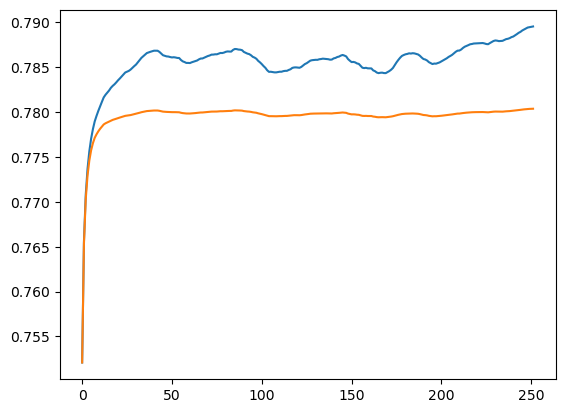

In [187]:
plt.plot(state_means[:,0])
plt.plot(state_means[:,1])

<AxesSubplot:xlabel='Date'>

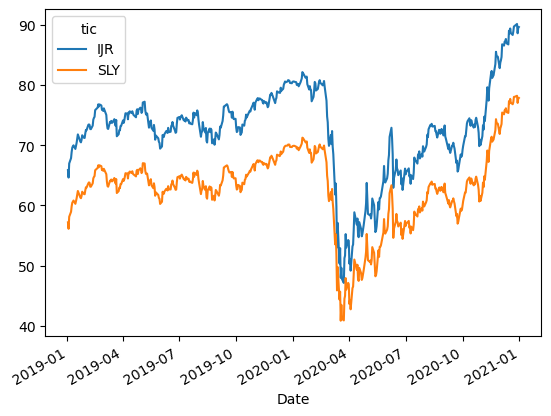

In [77]:
price_df_all.loc[:, pair_list[0]].plot()

In [56]:
df[idx][2].loc[:, pair_list[0]]

,VONE,VV
Date,,
2019-01-02,114.349998,114.879997
2019-01-03,111.860001,112.080002
2019-01-04,115.580002,115.940002
2019-01-07,116.589996,116.820000
2019-01-08,117.650002,117.949997
...,...,...
2020-01-27,148.610001,148.949997
2020-01-28,150.110001,150.429993
2020-01-29,149.949997,150.300003
